In [1]:
import numpy as np
from keras.datasets import cifar10
from keras.models import  Sequential, Model
from keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose
from keras.layers import Conv2D, Dropout, Flatten, Input, MaxPooling2D
from tqdm import trange
import cv2

%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
all_cifar = np.concatenate((x_train, x_test)) / 256
labels = np.concatenate((y_train, y_test))
print('Input data shape:', all_cifar.shape)

Input data shape: (60000, 32, 32, 3)


[ 8.  5.  3.  9.  2.  4.  8.  2.  6.  6.  0.  0.  0.  5.  5.  4.]


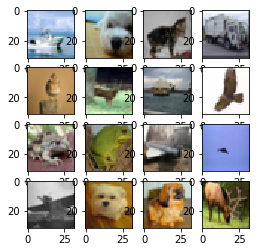

In [3]:
Nx = 4
Ny = 4

imgs_to_display = np.random.randint(all_cifar.shape[0], size=Nx*Ny)

fig = plt.figure(figsize=(Ny,Nx))
l = np.zeros((4*4))
for i in range(Ny):
    for j in range(Nx):
        k = i*Nx + j
        fig.add_subplot(Ny, Nx, k+1)
        plt.imshow(all_cifar[imgs_to_display[k]])
        l[k] = labels[imgs_to_display[k]]
print(l)

In [4]:
airplanes_indicies = labels==0
airplanes = np.empty((airplanes_indicies.sum(), 32, 32, 3))
j = 0
for i in range(airplanes_indicies.shape[0]):
    if airplanes_indicies[i]:
        airplanes[j] = all_cifar[i]
        j += 1

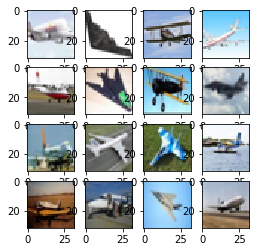

In [5]:
imgs_to_display = np.random.randint(airplanes.shape[0], size=Nx*Ny)

fig = plt.figure(figsize=(Ny,Nx))
for i in range(Ny):
    for j in range(Nx):
        k = i*Nx + j
        fig.add_subplot(Ny, Nx, k+1)
        plt.imshow(airplanes[imgs_to_display[k]])

In [6]:
class GAN:
    def __init__(self, images):
        self.images = images
        
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
        self.generator = self.build_generator()
        
        noise = Input(shape=(100,))
        img = self.generator(noise)
        
        self.discriminator.trainable = False
        
        out = self.discriminator(img)
        
        self.gan = Model(noise, out)
        self.gan.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
        self.gif_noise = np.random.rand(16, 100)
        self.to_gif = []
        
    def build_generator(self, level=0, generator=None):
        model = Sequential()

        model.add(Dense(2*2*256, use_bias=False, input_shape=(100,)))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.3))
        # shape: (2*2*512)

        model.add(Reshape((2,2,256)))
        # shape: (2,2,512)
        model.add(Conv2DTranspose(filters=128, kernel_size=(5,5), strides=(1,1), padding='same', use_bias=False))
        # shape: (2,2,256)
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.3))

        if level >= 1:
            model.add(Conv2DTranspose(filters=64, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False))
            # shape (4,4,128)
            model.add(BatchNormalization())
            model.add(LeakyReLU(alpha=0.3))
        
        if level >= 2:
            model.add(Conv2DTranspose(filters=32, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False))
            # shape (8,8,64)
            model.add(BatchNormalization())
            model.add(LeakyReLU(alpha=0.3))
            
        if level >= 3:
            model.add(Conv2DTranspose(filters=16, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False))
            # shape (16,16,64)
            model.add(BatchNormalization())
            model.add(LeakyReLU(alpha=0.3))

        model.add(Conv2DTranspose(filters=3, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False))
        # shape (x,x,3)
        
        if generator is not None:
            old_weights = generator.get_weights()
            new_weights = model.get_weights()
            
            old_len = len(old_weights)
            
            new_weights[:old_len-1] = old_weights[:-1]
            #new_weights[-1] = old_weights[-1]
            
            model.set_weights(new_weights)
        
        return model
    
    def build_discriminator(self, level=0, discriminator=None):
        model = Sequential()
        
        if level >= 3:
            model.add(Conv2D(32, kernel_size=(5,5), strides=(2,2), padding='same', input_shape=(32,32,3)))
            model.add(LeakyReLU())
            model.add(Dropout(0.3))
            #model.add(MaxPooling2D(pool_size=(2,2)))
            
        if level >= 2:
            model.add(Conv2D(64, kernel_size=(5,5), strides=(2,2), padding='same', input_shape=(16,16,3)))
            model.add(LeakyReLU())
            model.add(Dropout(0.3))
            #model.add(MaxPooling2D(pool_size=(2,2)))
            
        if level >= 1:
            model.add(Conv2D(128, kernel_size=(5,5), strides=(2,2), padding='same', input_shape=(8,8,3)))
            model.add(LeakyReLU())
            model.add(Dropout(0.3))
            #model.add(MaxPooling2D(pool_size=(2,2)))
            
        model.add(Conv2D(256, kernel_size=(5,5), strides=(2,2), padding='same', input_shape=(4,4,3)))
        model.add(LeakyReLU())
        model.add(Dropout(0.3))

        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        #if discriminator is not None:
        #    old_weights = discriminator.get_weights()
        #    new_weights = model.get_weights()
            
        #    print('old:', discriminator.summary())
        #    print('new:', model.summary())
            
        #    old_len = len(old_weights)
            
        #    new_weights[-old_len:] = old_weights
            
        #    model.set_weights(new_weights)
        
        return model
    
    def generate_images(self, n_images):
        return self.generator.predict(np.random.rand(n_images,100))
            
    def train(self, epochs, batch_size):
        g_input = np.empty((batch_size, 100))
        d_input = np.empty((batch_size, 32, 32, 3))
        
        d_labels = np.zeros((batch_size))
        d_labels[int(batch_size/2):] = 1
        
        g_labels = np.zeros((batch_size))
        
        for level in range(4):
            self.discriminator = self.build_discriminator(level, self.discriminator)
            self.discriminator.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
        
            self.generator = self.build_generator(level, self.generator)
        
            noise = Input(shape=(100,))
            img = self.generator(noise)
        
            self.discriminator.trainable = False
        
            out = self.discriminator(img)
        
            self.gan = Model(noise, out)
            self.gan.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
            if level == 0:
                d_input = np.empty((batch_size, 4, 4, 3))
            elif level == 1:
                d_input = np.empty((batch_size, 8, 8, 3))
            elif level == 2:
                d_input = np.empty((batch_size, 16, 16, 3))
            elif level == 3:
                d_input = np.empty((batch_size, 32, 32, 3))
            with trange(epochs) as t:
                for epoch in t:
                    idx = np.random.randint(self.images.shape[0], size=int(batch_size/2))

                    for i in range(int(batch_size/2)):
                        d_input[i] = cv2.resize(self.images[idx[i]], dsize=d_input.shape[1:3])

                    noise = np.random.rand(int(batch_size/2), 100)
                    d_input[int(batch_size/2):] = self.generator.predict(noise)

                    d_loss = self.discriminator.train_on_batch(d_input, d_labels)

                    g_input = np.random.rand(batch_size, 100)

                    g_loss = self.gan.train_on_batch(g_input, g_labels)

                    t.set_postfix(d_loss=d_loss[0], d_acc=d_loss[1], g_loss=g_loss[0], g_acc=g_loss[1])

                    if epoch % 20 == 0:
                        gif_output = self.generator.predict(self.gif_noise)
                        size = (level+1)*4
                        gif_i = np.empty((32*4, 32*4, 3))
                        for i in range(4):
                            for j in range(4):
                                gif_i[i*32: i*32+32, j*32:j*32+32] = cv2.resize(gif_output[i*4+j], dsize=(32,32)) 
                        self.to_gif.append(gif_i)
            
            
 

In [11]:
cifar_GAN = GAN(airplanes)

In [12]:
cifar_GAN.train(5000, 128)

  0%|          | 0/5000 [00:00<?, ?it/s]/home/mateusz/.local/lib/python3.6/site-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
100%|██████████| 5000/5000 [05:44<00:00, 14.51it/s, d_acc=0.812, d_loss=0.413, g_acc=0.0234, g_loss=2.07]  


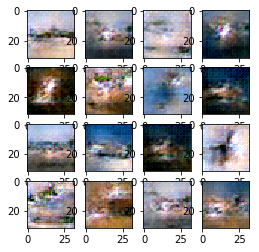

In [15]:
out = cifar_GAN.generator.predict(np.random.rand(16,100))
fig = plt.figure(figsize=(Ny,Nx))
for i in range(Ny):
    for j in range(Nx):
        k = i*Nx + j
        fig.add_subplot(Ny, Nx, k+1)
        plt.imshow(out[k])

In [14]:
import imageio as io

io.mimwrite('cifar.gif', cifar_GAN.to_gif)